In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from math import *
import pickle
import pandas as pd
from tqdm import tqdm
from aero_info import *
from missile_gym import MissileGym

In [2]:
opts = {
    'm_0': 2402.896642527979,
    'd': 0.515,
    'vel_abs': 1410,
    't_marsh': 11.602913766241713,
    'w_marsh': 1417.7090190915076,
    'P_marsh': 329901.12903225806,
    'dt': 0.01,
    'tau': 1/20,
    't_max': 150,
    'I': 2700,
    'r_kill': 50,
    'alpha_max': 20,
    'speed_change_alpha': 64,
    'xi': 0.5,
    'am': 6,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'Q_0': 75, 'pos_0': (0, 0)},
    'L_korp': 7690 / 1e3,
    'L_cil': 4567 / 1e3,
    'L_korm': 135 / 1e3,
    'L_oper': 1200 / 1e3,
    'L_kon1': 1360 / 1e3,
    'L_kon2': 1628 / 1e3,
    'b_0_oper': 1360.030793 / 1e3,
    'x_b_oper': 6.5,
    'a': 0.2,
    'betta_kon2': 1,
    'd_korm': 515 / 1e3,
    'c_oper': 0.03,
    'khi_pk_oper': 50,
    'khi_rul': 90,
    'class_korp': 7,
    'class_oper': 5,
    'S_oper': 1.20092864206,
    'x_ct_0': 4.5066951078603825,
    'x_ct_marsh': 3.921345267027331,
}

In [3]:
def foo_gym_hit(x, y, V_c, aero=False, record=False, render=False):
    gym = MissileGym.make_simple_scenario(opts, (x, y), (V_c, 0))
    done = False
    obs = gym.reset()
    state = gym.get_state()
    history = [(state, obs, done, {}, {})]
    alphas_targeting = [0]
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        if render == True:
            fig, ax = plt.subplots()
            gym.render(fig = fig, ax = ax)
            plt.title('Полет ракеты и цели')
            plt.show()
        aero_res = gym.get_aero_constants() if aero == True else {}
        history.append((state, obs, done, info, aero_res))
        alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alpha_max else copysign(gym.missile.alpha_max, gym.missile.alpha_targeting))
    inf = info['done_reason']
    print(f'info = {inf}; x = {x}; y = {y}')
    if record is True:
        return {'history': history, 'alphas_targeting': alphas_targeting}
    else:
        return state, obs, done, info, aero_res

In [4]:
xc_max = 10e3
yc_max = 25e3
V_c = -300

In [5]:
%time res_hit = foo_gym_hit(xc_max, yc_max, V_c, aero=True, record=True, render=False)

meet: True; meeting point: [ 4591.87072686 25000.        ]
info = target destroyed; x = 10000.0; y = 25000.0
Wall time: 1min 29s


In [6]:
mvels = []
mtaus = []
mxs = []
mys = []
txs = []
tys = []
for t in range(len(res_hit['history'])):
    mvels.append(res_hit['history'][t][0][0])
    mtaus.append(res_hit['history'][t][0][5])
    mxs.append(res_hit['history'][t][0][1])
    mys.append(res_hit['history'][t][0][2])
    txs.append(res_hit['history'][t][0][6])
    tys.append(res_hit['history'][t][0][7])

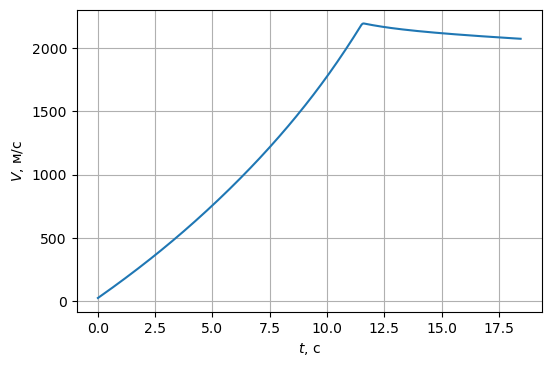

In [7]:
plt.figure(dpi=100)
plt.plot(mtaus, mvels)
plt.grid()
plt.ylabel('$V$, м/с')
plt.xlabel('$t$, с')
plt.show()

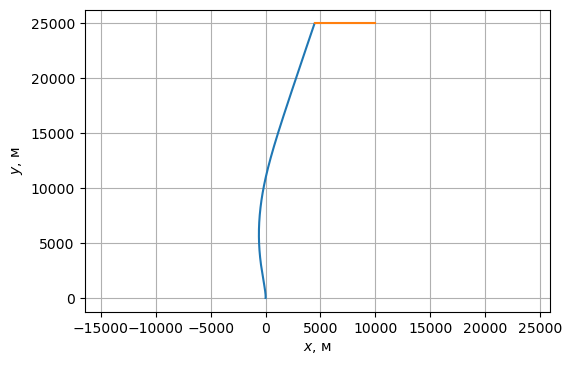

In [8]:
%matplotlib inline
plt.figure(dpi=100)
plt.plot(mxs, mys)
plt.plot(txs, tys)
plt.grid()
plt.ylabel('$y$, м')
plt.xlabel('$x$, м')
plt.axis('equal')
plt.show()

In [11]:
aero_res = []
for i in range(len(res_hit['history'])):
    aero_res.append(res_hit['history'][i][-1])

In [12]:
Cya = []
Cx  = []
t   = []
alpha = []
for i in range(1, len(aero_res)):
    Cya.append(aero_res[i]['Cy_alpha'])
    Cx.append(aero_res[i]['Cx'])
    t.append(aero_res[i]['t'])
    alpha.append(aero_res[i]['alpha'])

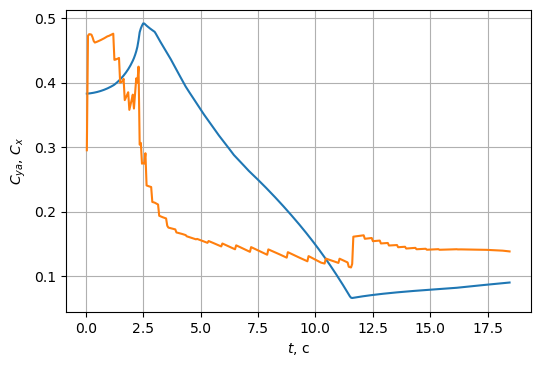

In [13]:
plt.figure(dpi=100)
plt.plot(t, Cya)
plt.plot(t, Cx)
plt.grid()
plt.ylabel('$C_{ya}$, $C_{x}$')
plt.xlabel('$t$, с')
plt.show()

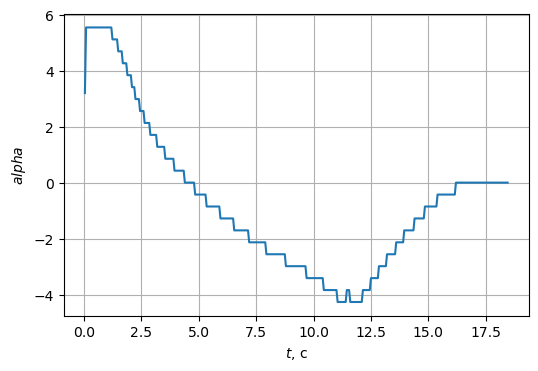

In [14]:
plt.figure(dpi=100)
plt.plot(t, alpha)
plt.grid()
plt.ylabel('$alpha$')
plt.xlabel('$t$, с')
plt.show()